In [1]:
#!pip install requirements.txt


# After preparing the data, save it to a csv file to use in other models directly

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from snowballstemmer import TurkishStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import naive_bayes, svm

In [2]:
human_data = load_dataset('kmkarakaya/turkishReviews-ds')
human_data = human_data['train'].to_pandas()
human_data.head()

,review,review_length
0,Okan Üniversitesi Hastanesi'nde Çalışanların S...,45
1,Ekici Kaşar Peynirinin Peynir İle Alakası Yok....,49
2,Similac 2 Devam Sütunun İçinden Tahta Çıktı. ...,55
3,İlhan Duman Hukuk Bürosu Borç Mesajı Geliyor. ...,44
4,Samsung Kamera Flaş Sorunu. Alalı 1 gün oldu S...,40


In [3]:
# Some parts of this dataset is used for AI generated review production, so we need to filter out those
human_data = human_data.iloc[3000:].reset_index(drop=True)
human_data.shape

(395772, 2)

In [4]:
human_data.columns

Index(['review', 'review_length'], dtype='object')

In [5]:
# All the reviews contain their titles as the first sentence. They can be removed to make the dataset more clean.
human_data['review'] = human_data['review'].apply(lambda x: re.sub(r'^.*\n', '', x))

# Update review lengths after removing titles
human_data['review_length'] = human_data['review'].apply(lambda x: len(x.split()))

human_data.head()

,review,review_length
0,Stüdyo Burak (Eskişehir) Biyometrik Vesikalık ...,46
1,Ziraat Bankası Konut Kredisi Yapılandırma. Ağu...,46
2,Grundig Televizyon Aldığımdan Beri Arıza Veriy...,48
3,Sürat Kargo Teslim Edilemeyen Ürünler. 7790108...,42
4,Okan Üniversitesi Ödenen Paranın Geri Verilmes...,52


In [6]:
ai_data = pd.read_excel('ai_data.xlsx')
ai_data.head()

,prompt,review,model
0,Okan Üniversitesi Hastanesi'nde Çalışanların S...,Okan Üniversitesi Hastanesi'nde çalışanların s...,gpt-3.5-turbo
1,Ekici Kaşar Peynirinin Peynir İle Alakası Yok....,Ekici Kaşar Peyniri tam bir hayal kırıklığı! M...,gpt-3.5-turbo
2,Similac 2 Devam Sütunun İçinden Tahta Çıktı. ...,Similac 2 Devam Sütü aldığımda içinden tahta ç...,gpt-3.5-turbo
3,İlhan Duman Hukuk Bürosu Borç Mesajı Geliyor. ...,İlhan Duman Hukuk Bürosu'ndan sürekli borç mes...,gpt-3.5-turbo
4,Samsung Kamera Flaş Sorunu. Sen bir tüketicis...,Samsung marka kameramın flaşıyla ilgili yaşadı...,gpt-3.5-turbo


In [7]:
print("AI Data Shape: ", ai_data.shape)
print("Human Data Shape: ", human_data.shape)
print("Human Data:\n", human_data.describe())
print("Human Data Columns: ", human_data.columns)
print("Human Data Number of Words: ", human_data['review_length'].mean())
print("Human Data Maximum Number of Words: ", human_data['review_length'].max())
print("Human Data Minimum Number of Words: ", human_data['review_length'].min())

AI Data Shape:  (5800, 3)
Human Data Shape:  (395772, 2)
Human Data:
        review_length
count  395772.000000
mean       46.002044
std         5.194381
min        29.000000
25%        43.000000
50%        46.000000
75%        49.000000
max       176.000000
Human Data Columns:  Index(['review', 'review_length'], dtype='object')
Human Data Number of Words:  46.00204410620256
Human Data Maximum Number of Words:  176
Human Data Minimum Number of Words:  29


In [8]:
# Human dataset
print("Human Data Shape: ", human_data.shape)
print("Human Data: ", human_data.describe())
print("Human Data Num of Words: ", human_data['review_length'].mean())

Human Data Shape:  (395772, 2)
Human Data:         review_length
count  395772.000000
mean       46.002044
std         5.194381
min        29.000000
25%        43.000000
50%        46.000000
75%        49.000000
max       176.000000
Human Data Num of Words:  46.00204410620256


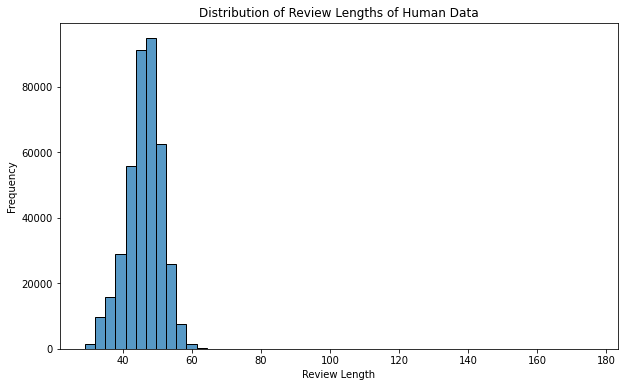

In [9]:
# Text Length Distribution for Human Data
plt.figure(figsize=(10, 6))
sns.histplot(human_data['review_length'], bins=50)
plt.title('Distribution of Review Lengths of Human Data')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

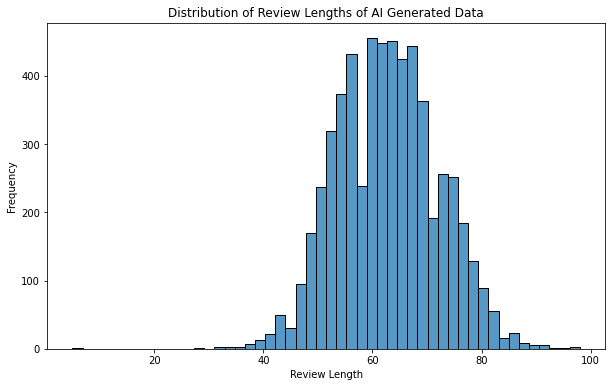

In [10]:
# Text Length Distribution for AI Data
ai_data['review_length'] = ai_data['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(ai_data['review_length'], bins=50)
plt.title('Distribution of Review Lengths of AI Generated Data')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
ai_data['label'] = 'ai'
ai_data = ai_data[['review', 'label']]
human_data['label'] = 'human'

dataset = pd.concat([human_data, ai_data], ignore_index=True)
dataset

,review,review_length,label
0,Stüdyo Burak (Eskişehir) Biyometrik Vesikalık ...,46.0,human
1,Ziraat Bankası Konut Kredisi Yapılandırma. Ağu...,46.0,human
2,Grundig Televizyon Aldığımdan Beri Arıza Veriy...,48.0,human
3,Sürat Kargo Teslim Edilemeyen Ürünler. 7790108...,42.0,human
4,Okan Üniversitesi Ödenen Paranın Geri Verilmes...,52.0,human
...,...,...,...
401567,Philips Süpürge Borusu Kırılması. Philips mark...,NaN,ai
401568,Asdem Beach Hotel'de kaldım ve ciddi sorunlar ...,NaN,ai
401569,Palette 12.1 Buzul Sarı Saç Yanması ile ilgili...,NaN,ai
401570,Çöz Sigorta'dan 20 gündür şikayetçiyim. Poliçe...,NaN,ai


# Preprocess AI Generated Data

In [12]:
# Stopwords listesi yükleniyor
nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# Kelime kökü bulucu
stemmer = TurkishStemmer()

def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    # Noktalama işaretlerini çıkarma
    text = re.sub(r'[^\w\s]', '', text)
    # Rakamları çıkarma
    text = re.sub(r'\d+', '', text)
    # Tokenleme
    words = word_tokenize(text)
    # Durdurma kelimelerini çıkarma ve stemming
    words = [stemmer.stemWord(word) for word in words if word not in turkish_stopwords]
    # Temizlenmiş metni birleştirme
    return ' '.join(words)

# AI veri setindeki metinleri ön işlemeden geçirme
ai_data['review'] = ai_data['review'].apply(preprocess_text)
print(ai_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                 review label
0     oka üniversites hastane çalışa son zaman göste...    ai
1     ekiç kaşar peynir tam bir hayal kırıklık marke...    ai
2     similaç deva süt aldık iç tah çık bebek ür tük...    ai
3     ilha duma hukuk büro sürekli borç mesaj alıyor...    ai
4     samsungu marka kamera flaş ilgil yaşadık sor i...    ai
...                                                 ...   ...
5795  philips süpürge borus kırılmas philips marka s...    ai
5796  asde beach hotel kal cidi sorun yaşadı oda tel...    ai
5797  palet buzul sar saç yanmas ilgil yaşadık sor p...    ai
5798  çöz sigorta g şikayetçi poliçe yer ala hasar ö...    ai
5799  merhap eba eğit biliş site son güncelleme sonr...    ai

[5800 rows x 2 columns]


In [13]:
sampling = human_data.iloc[0:3].reset_index(drop=True)
print(sampling['review'][0], "\n")
print(preprocess_text(sampling['review'][0]), "\n")
print(sampling['review'][1], "\n")
print(preprocess_text(sampling['review'][1]), "\n")
print(sampling['review'][2], "\n")
print(preprocess_text(sampling['review'][2]), "\n")

Stüdyo Burak (Eskişehir) Biyometrik Vesikalık Hatalı Çekiliyor. Ehliyet için 12 Biyometrik vesikalığı 50 TL'ye çekiyorlar, Sürücü kursu arka fonun sistemde hata verdiğini ve Stüdyonun negatifi e-mail göndermesi gerektiğini iletti. Telefonda e-mail için 10 TL istediklerini ve Stüdyo'ya gelmem gerektiğini ilettiler. Yaptıkları iş hatalı, ayrıca insan psikolojisind 

stüdyo burak eskişehir biyometrik vesikalık hatal çekiliyor ehliyet biyometrik vesikalık tlye çekiyor sürüç kursu arka fo siste ha verdik stüdyo negatif email göndermes gerektik ilet telefo email tl istedik stüdyo gelme gerektik ilet yaptık iş hatal ayrıç in psikolojisindi 

Ziraat Bankası Konut Kredisi Yapılandırma. Ağustos 2019 tarihinde %0. 99 faiz oranı ile bankanızdan kullanmış olduğum konut kredim bulunmaktadır. Açıklanan son güncel kredi paketleri kapsamında %0. 74 oranına düşürülen konut kredisi faiz oranından yararlanmayı ve oluşan hak kaybımın giderilmesini Tüketiciyi Koruma Kanununun 36 ve 37. Maddeleri 

ziraat ba

In [14]:
ai_data.head()

,review,label
0,oka üniversites hastane çalışa son zaman göste...,ai
1,ekiç kaşar peynir tam bir hayal kırıklık marke...,ai
2,similaç deva süt aldık iç tah çık bebek ür tük...,ai
3,ilha duma hukuk büro sürekli borç mesaj alıyor...,ai
4,samsungu marka kamera flaş ilgil yaşadık sor i...,ai


In [15]:
human_data.head()

,review,review_length,label
0,Stüdyo Burak (Eskişehir) Biyometrik Vesikalık ...,46,human
1,Ziraat Bankası Konut Kredisi Yapılandırma. Ağu...,46,human
2,Grundig Televizyon Aldığımdan Beri Arıza Veriy...,48,human
3,Sürat Kargo Teslim Edilemeyen Ürünler. 7790108...,42,human
4,Okan Üniversitesi Ödenen Paranın Geri Verilmes...,52,human


In [16]:
human = human_data.iloc[-len(ai_data):].copy()
human['review'] = human['review'].apply(preprocess_text)
human.drop('review_length', axis=1, inplace=True)
human.head()

,review,label
389972,farabi hastanes konya öde sor devlet hastane b...,human
389973,sürat kargo kargo getiremedi tarih verdik sipa...,human
389974,apple değiş ola ekra el deforme ür takılmas pl...,human
389975,molfix şekerle bez molfix numar bez al bez şek...,human
389976,huawei p li isınma kasılma sor ay ö teknos dan...,human


In [17]:
combined_df = pd.concat([ai_data, human], ignore_index=True)
combined_df.to_csv('reviews.csv', index=False)

## Training Models

In [33]:
# Initialize lists to store results
all_accuracies = {'LR': [], 'NB': [], 'SVM': []}
all_f1_scores = {'LR': [], 'NB': [], 'SVM': []}
all_conf_matrices = {'LR': [], 'NB': [], 'SVM': []}

# Loop to train and evaluate models
for i in range(5):
    # Augment AI data and sample human data
    train_ai, test_ai = train_test_split(ai_data, test_size=0.3, random_state=i)
    sampled_human_data = human_data.sample(n=len(ai_data), random_state=i)
    
    # Preprocess sampled human data
    sampled_human_data['review'] = sampled_human_data['review'].apply(preprocess_text)
    train_human_df, test_human_df = train_test_split(sampled_human_data, test_size=0.3, random_state=i)
    
    # Combine and shuffle datasets
    combined_train_df = pd.concat([train_ai, train_human_df])
    combined_test_df = pd.concat([test_ai, test_human_df])

    # Encode labels
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(combined_train_df['label'])
    Test_Y = Encoder.transform(combined_test_df['label'])

    # Vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(pd.concat([ai_data['review'], human_data['review']]))  # Use full text data for fitting
    Train_X_Tfidf = Tfidf_vect.transform(combined_train_df['review'])
    Test_X_Tfidf = Tfidf_vect.transform(combined_test_df['review'])

    # Logistic Regression
    vectorizer = CountVectorizer(ngram_range=(1,3))
    X_train = vectorizer.fit_transform(combined_train_df['review'])
    X_test = vectorizer.transform(combined_test_df['review'])

    log_reg = LogisticRegression()
    log_reg.fit(X_train, Train_Y)

    predictions_LR = log_reg.predict(X_test)
    acc_lr = round(accuracy_score(predictions_LR, Test_Y), 4)
    f1_lr = round(f1_score(Test_Y, predictions_LR, average='weighted'), 4)
    all_accuracies['LR'].append(acc_lr)
    all_f1_scores['LR'].append(f1_lr)
    all_conf_matrices['LR'].append(confusion_matrix(Test_Y, predictions_LR))

    # Naive Bayes
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(Train_X_Tfidf, Train_Y)
    predictions_NB = Naive.predict(Test_X_Tfidf)
    acc_naive = round(accuracy_score(predictions_NB, Test_Y), 4)
    f1_naive = round(f1_score(Test_Y, predictions_NB, average='weighted'), 4)
    all_accuracies['NB'].append(acc_naive)
    all_f1_scores['NB'].append(f1_naive)
    all_conf_matrices['NB'].append(confusion_matrix(Test_Y, predictions_NB))

    # SVM
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf, Train_Y)
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    acc_svm = round(accuracy_score(predictions_SVM, Test_Y), 4)
    f1_svm = round(f1_score(Test_Y, predictions_SVM, average='weighted'), 4)
    all_accuracies['SVM'].append(acc_svm)
    all_f1_scores['SVM'].append(f1_svm)
    all_conf_matrices['SVM'].append(confusion_matrix(Test_Y, predictions_SVM))
    print(f"{i+1}. Iteration -> LR Acc: {acc_lr}, LR F1: {f1_lr}, NB Acc: {acc_naive}, NB F1: {f1_naive}, SVM Acc: {acc_svm}, SVM F1: {f1_svm}")

# Final results
print("Logistic Regression - Average Accuracy:", round(np.mean(all_accuracies['LR']), 4))
print("Logistic Regression - Average F1 Score:", round(np.mean(all_f1_scores['LR']), 4))
print("Naive Bayes - Average Accuracy:", round(np.mean(all_accuracies['NB']), 4))
print("Naive Bayes - Average F1 Score:", round(np.mean(all_f1_scores['NB']), 4))
print("SVM - Average Accuracy:", round(np.mean(all_accuracies['SVM']), 4))
print("SVM - Average F1 Score:", round(np.mean(all_f1_scores['SVM']), 4))

1. Iteration -> LR Acc: 0.9906, LR F1: 0.9906, NB Acc: 0.9517, NB F1: 0.9516, SVM Acc: 0.9844, SVM F1: 0.9844
2. Iteration -> LR Acc: 0.9856, LR F1: 0.9856, NB Acc: 0.9533, NB F1: 0.9532, SVM Acc: 0.9778, SVM F1: 0.9778
3. Iteration -> LR Acc: 0.9878, LR F1: 0.9878, NB Acc: 0.9561, NB F1: 0.956, SVM Acc: 0.9794, SVM F1: 0.9794
4. Iteration -> LR Acc: 0.9894, LR F1: 0.9894, NB Acc: 0.9444, NB F1: 0.9443, SVM Acc: 0.9856, SVM F1: 0.9856
5. Iteration -> LR Acc: 0.9883, LR F1: 0.9883, NB Acc: 0.9556, NB F1: 0.9555, SVM Acc: 0.9889, SVM F1: 0.9889
Logistic Regression - Average Accuracy: 0.9883
Logistic Regression - Average F1 Score: 0.9883
Naive Bayes - Average Accuracy: 0.9522
Naive Bayes - Average F1 Score: 0.9521
SVM - Average Accuracy: 0.9832
SVM - Average F1 Score: 0.9832


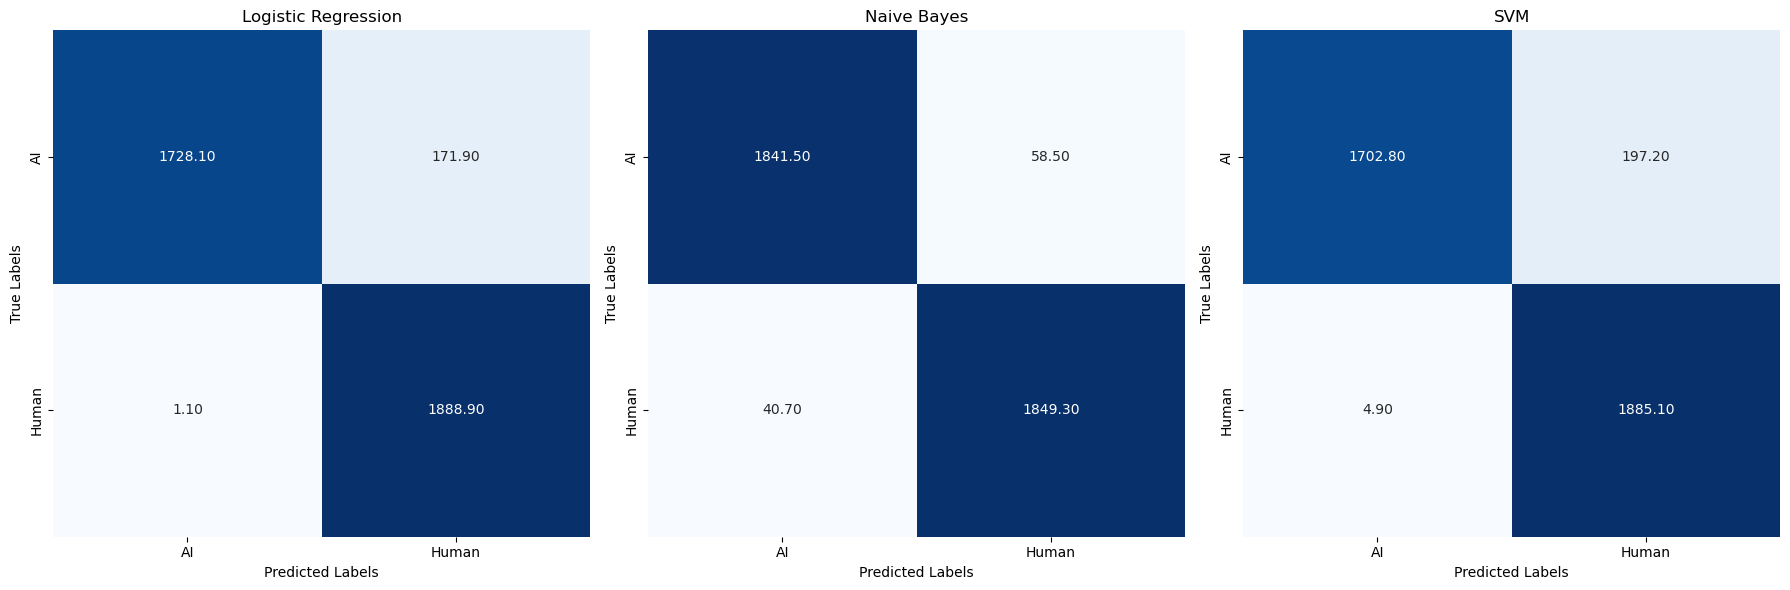

In [17]:
# Define function to calculate the mean of confusion matrices
def mean_confusion_matrix(conf_matrices):
    sum_matrix = np.zeros_like(conf_matrices[0])
    for matrix in conf_matrices:
        sum_matrix += matrix
    return sum_matrix / len(conf_matrices)

# Calculate mean confusion matrices for each model
mean_cm_LR = mean_confusion_matrix(all_conf_matrices['LR'])
mean_cm_NB = mean_confusion_matrix(all_conf_matrices['NB'])
mean_cm_SVM = mean_confusion_matrix(all_conf_matrices['SVM'])

def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['AI', 'Human'])
    ax.set_yticklabels(['AI', 'Human'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_confusion_matrix(mean_cm_LR, 'Logistic Regression', axes[0])
plot_confusion_matrix(mean_cm_NB, 'Naive Bayes', axes[1])
plot_confusion_matrix(mean_cm_SVM, 'SVM', axes[2])
plt.tight_layout()
plt.show()

The model seem to work too good. Let's see the results with cross validation

Cross-Validation Average Accuracy: 0.9995459704880817
Test Set Accuracy: 0.9559366754617414
Classification Report on Test Set:
               precision    recall  f1-score   support

          ai       1.00      0.91      0.95      1900
       human       0.92      1.00      0.96      1890

    accuracy                           0.96      3790
   macro avg       0.96      0.96      0.96      3790
weighted avg       0.96      0.96      0.96      3790



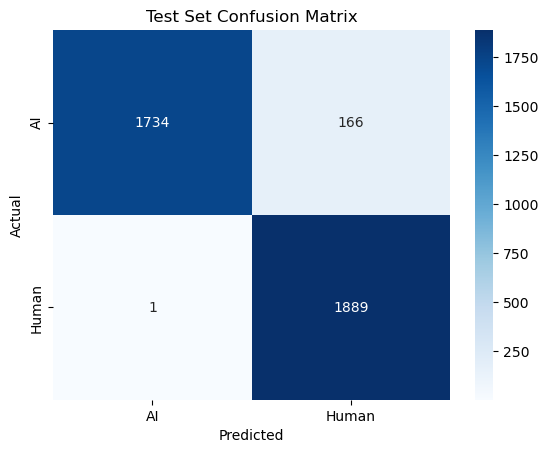

In [21]:
# Split data into training and testing sets
vectorizer = CountVectorizer(ngram_range=(1,3))
X_train = vectorizer.fit_transform(combined_train_df['review'])
X_test = vectorizer.transform(combined_test_df['review'])

y_train = combined_train_df['label'].values
y_test = combined_test_df['label'].values

# Initialize KFold for the training set only
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Lists to store results for each fold
accuracies = []
class_reports = []
conf_matrices = []

# Perform cross-validation on the training data only
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model on the fold
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    predictions = model.predict(X_val_fold)
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_val_fold, predictions))
    class_reports.append(classification_report(y_val_fold, predictions, output_dict=True))
    conf_matrices.append(confusion_matrix(y_val_fold, predictions))

# Evaluate the final model on the test set
final_predictions = model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)
final_class_report = classification_report(y_test, final_predictions)
final_conf_matrix = confusion_matrix(y_test, final_predictions)

# Display results
print("Cross-Validation Average Accuracy:", np.mean(accuracies))
print("Test Set Accuracy:", final_accuracy)
print("Classification Report on Test Set:\n", final_class_report)

# Display confusion matrix for the test set
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test Set Confusion Matrix')
plt.show()